# Basic Image Manipulation

Andreu Casas and Nora Webb Williams | May, 2019


**Purpose:**

In this module you will learn how to perform the following tasks with images:

    - load them
    - crop and resize them
    - flatten them to create image vector/embeddings
    - use the vector/embeddings to evaluate image similarity
    - classify images using a pretrained convolutional neural net (VGG16)

### Modules

In [1]:
# Import all the needed python packages
from __future__ import print_function, division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
plt.ion()   # interactive mode
import os
import pickle
import json
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set()
import torchvision.transforms as transforms

In [3]:
os.getcwd()

'/root/capsule/code/images_as_data/notebooks'

### Paths & Constants

In [4]:
DATA_PATH = '../data/'

### [A] Loading images

In [5]:
# - use the PIL module to load images. Store them in a list
all_imgfiles = ['fbt_ex01.jpg', 'fbt_ex02.jpg', 'fbt_ex03.jpg', 'fbt_ex04.jpg']
images = []
for img_file in all_imgfiles:
    img = Image.open('{}image-manipulation/{}'.format(DATA_PATH,img_file)).convert('RGB')
    images.append(img)

In [6]:
# - transform the image to a NumPy array and take a look at its structure (900x1200x3)
img_array01 = np.array(images[0])
img_array01.shape

(820, 470, 3)

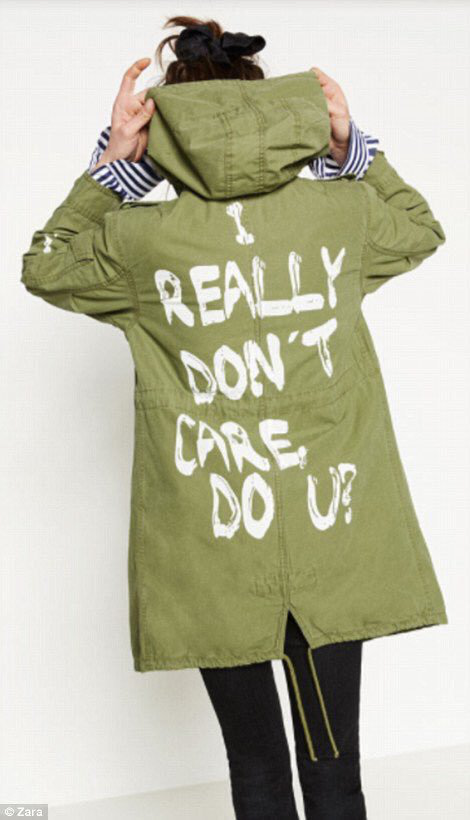

In [7]:
# - print the image so you can take a look at it
images[0]

### [B] Crop & Resize images

In [8]:
# - you can use the 'resize' PIL image objects to resize images. This can be useful for:
#   ... reducing image size so you they don't take that much storage

# (e.g. reducing image width and height by 30%)
smaller_images = []
for img in images:
    smaller_img = img.resize((int(img.width * 0.5), int(img.height * 0.5)))
    smaller_images.append(smaller_img)

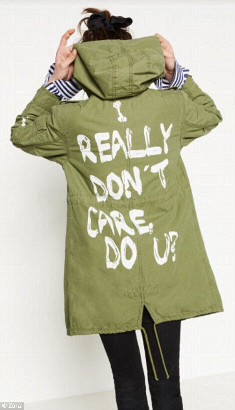

In [9]:
# - print the same image but 50% smaller
smaller_images[0]

In [10]:
# ... resizing images is also useful for getting the images ready to be fit to
#     a pre-trained Convolutional Neural Net with fixed input size. For example,
#     the required input size for a commonly used pretrained CNN (ResNet), is
#     224x224x3.
images_resnetsize = []
for img in images:
    smaller_img = img.resize((224,224))
    images_resnetsize.append(smaller_img)

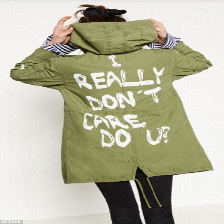

In [11]:
# - print the same image after resizing it for ResNet
images_resnetsize[0]

In [12]:
# - this is not ideal because, since the original image wasn't square, the resized 
#   224x224 version is a bit deformed. To avoid deforming the image while still 
#   resizing it to 224x224, crop out the top and the bottom first.

# ... calculate the difference between the height and the width, to see how much of
#     the top/bottom OR left/right you'll need to crop. Then go ahead and crop those
#     parts out before resizing to 224x224
crop_res_images = []
for img in images:
    height = img.height
    width = img.width
    hw_dif = abs(height - width)
    hw_halfdif = hw_dif / 2
    crop_leftright = width > height
    if crop_leftright:
        y0 = 0
        y1 = height
        x0 = 0 + hw_halfdif
        x1 = width - hw_halfdif        
    else:
        y0 = 0 + hw_halfdif
        y1 = height - hw_halfdif
        x0 = 0
        x1 = width
    cropped_img = img.crop((x0, y0, x1, y1))
    cropped_resized = cropped_img.resize((224,224))
    crop_res_images.append(cropped_resized)


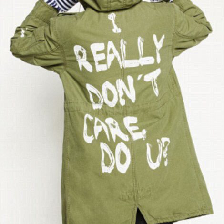

In [13]:
# - see how they are all square now
crop_res_images[0]

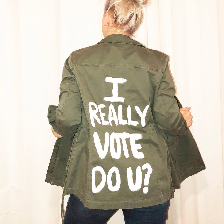

In [14]:
crop_res_images[1]

### [C] Flatten images

In [15]:
# - The nice things about cropping and resizing images to the same size is that
#   then we can more easily compare them

# - For example, one can transform the 3-d matrices to flat vectors and
#   then use vector similarity measures such as Cosine Similarity to find duplicate
#   images or to find images that are similar to each other

In [16]:
# ... let's reduce the images even more so we don't generate vectors a crazy size
verysmall_images = []
for img in images:
    height = img.height
    width = img.width
    hw_dif = abs(height - width)
    hw_halfdif = hw_dif / 2
    crop_leftright = width > height
    if crop_leftright:
        y0 = 0
        y1 = height
        x0 = 0 + hw_halfdif
        x1 = width - hw_halfdif        
    else:
        y0 = 0 + hw_halfdif
        y1 = height - hw_halfdif
        x0 = 0
        x1 = width
    cropped_img = img.crop((x0, y0, x1, y1))
    cropped_resized = cropped_img.resize((15,15)) ###### 15 X 15 #######
    verysmall_images.append(cropped_resized)

In [17]:
# - take a look at the size of the images we'll flatten. They are pretty small (15x15), but
#   the resulting will be already of a considerable size: 15x15x3 = 650
verysmall_images[0]

In [18]:
# - now let's transform these very small 3d image matrices to vector by flatting them out
img_vectors = []
for vsmall_img in verysmall_images:
    img_vect = list(np.array(vsmall_img).flatten())
    img_vectors.append(img_vect)

# What's a vector? Uncomment and print the first one to see    
#img_vectors[0]

### [D] Image similarity

In [19]:
# - let's explore image similarity. Let's first stack the list of vectors into a 
#   numpy matrix to which we'll then easily fit a cosine_similarity function calculating
#   the similrity between each possible row pair.
img_array = np.array(img_vectors)

In [20]:
img_array.shape

(4, 675)

In [21]:
img_array

array([[243, 243, 241, ..., 244, 244, 242],
       [251, 251, 243, ..., 245, 230, 211],
       [ 68,  85,  77, ...,  16,  15,  13],
       [104, 152, 226, ...,  20,  21,  25]], dtype=uint8)

In [22]:
# - calculate cosine similarity
sim_mat = cosine_similarity(img_array)

In [23]:
# - look at the resulting similarity matrix
sim_mat

array([[ 1.        ,  0.9399151 ,  0.66485104,  0.73504784],
       [ 0.9399151 ,  1.        ,  0.61646649,  0.72786279],
       [ 0.66485104,  0.61646649,  1.        ,  0.68712024],
       [ 0.73504784,  0.72786279,  0.68712024,  1.        ]])

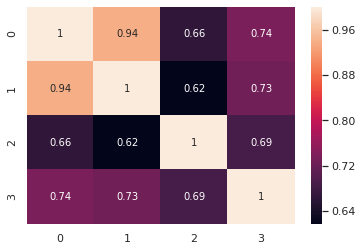

In [24]:
# - let's plot these image similarities using a heat map.
ax = sns.heatmap(sim_mat, annot=True)

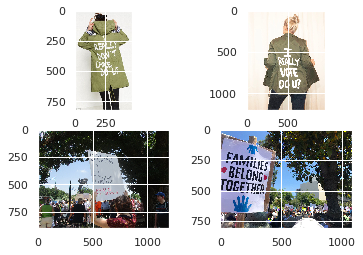

In [25]:
# - image #1 is the most similar to image #0
# - image #2 is sipposed to be similar to #3
# ... let's see:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])

### [E] Image classification with pre-trained CNN

In [26]:
# - load a pretrained CNN trained for ImageClassification (VGG16)
# NOTE: This step can take a while
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100.0%


In [27]:
# - take a look at the model architecture
model

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [28]:
# - load a file with the 1,000 class labels
inet_labs = json.load(open('{}image-manipulation/imagenet_class_index.json'.format(DATA_PATH, 'rb')))

In [29]:
# - take a look at the type of object classes into which VGG16 classifies images
inet_labs

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [30]:
# - a function to preprocess an image file so it fits the VGG16 input requirements.
#   This function already does the cropping and resizing for you
def data_tranform(train = True, mean = [0.485, 0.456, 0.406], 
                  sd = [0.229, 0.224, 0.225],
                  scale = 256, random_crop = 224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.    
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of 
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)                    
    Output:
        An object to be used for preprocessing the train and test images        
    Example:
        preprocess = data_transform()        
    """
    if train:
        data_transforms = transforms.Compose([
                transforms.Scale(scale),            
                transforms.RandomSizedCrop(random_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ])
    else:
        data_transforms = transforms.Compose([
            transforms.Scale(scale),
            transforms.CenterCrop(random_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, sd)
        ])        
    return(data_transforms)

In [31]:
# - pass the images through the VGG16 and get some model predictions
vgg16_preprocess = data_tranform(train = False) # a function to preprocess/normanlize data
softmax = torch.nn.Softmax() # a softmax model to transform model predictions to predicted prob
pred_labels = pd.DataFrame()
for img_file in all_imgfiles:
    # ... load the image
    img = Image.open('{}image-manipulation/{}'.format(DATA_PATH, img_file)).convert('RGB')
    # ... preprocess/normalize the image
    img_transformed = Variable(vgg16_preprocess(img).unsqueeze(0))
    # ... model predictions
    model_out = model(img_transformed)
    # ... transform model predictions to predicted probabilities
    pred_probs = softmax(model_out)
    # ... pull the maximum predicted pr and class
    max_pr, max_class = torch.max(pred_probs, dim = 1)
    # ... pull the human-readable label for this max class
    max_label = inet_labs[str(max_class.data[0])][1]
    # ... save the info
    new_row = pd.DataFrame({
        'img_file':img_file,
        'max_pr':round(max_pr.data[0], 4),
        'max_label':max_label
    }, index = [0])
    pred_labels = pd.concat((pred_labels, new_row))

In [32]:
pred_labels

,img_file,max_pr,max_label
0,fbt_ex01.jpg,0.8442,jersey
0,fbt_ex02.jpg,0.7966,bulletproof_vest
0,fbt_ex03.jpg,0.2418,moving_van
0,fbt_ex04.jpg,0.9423,street_sign


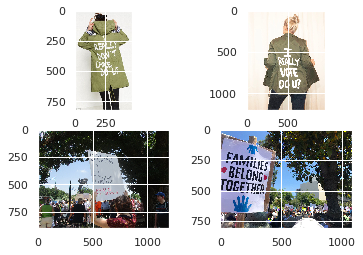

In [33]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])